## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, train=True, transform=train_transform, target_transform=None, download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, train=False, transform=test_transform, target_transform=None, download=download)

In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test, batch_size=256, shuffle=False, num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
    #print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 256),
            nn.Tanh(),
            nn.Linear(256, 512),
            nn.Tanh(),
            nn.Linear(512, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              Tanh-3                  [-1, 256]               0
            Linear-4                  [-1, 512]         131,584
              Tanh-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
Total params: 337,674
Trainable params: 337,674
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.29
Estimated Total Size (MB): 1.31
----------------------------------------------------------------


Your experiments come here:

In [ ]:
def train_epoch(model, device, train_loader, test_loader, criterion, optimizer): 
    torch.manual_seed(5)

    model.train()

    current_test_accuracy = 0
    running_loss = 0
    pred = 0
    correct = 0
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label.view_as(pred)).sum().item()
    
    current_loss = running_loss / len(train_loader.dataset)
    print(f'train loss = {current_loss}')
    current_train_accuracy = correct / len(train_loader.dataset)
    print(f'train accuracy = {current_train_accuracy}')

    model.eval()

    current_test_loss = 0
    current_test_accuracy = 0 

    test_loss = 0
    correct = 0   
    running_loss = 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss = criterion(output, label)
            running_loss += test_loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

    current_test_loss = running_loss / len(test_loader.dataset) 
    print(f'test loss = {current_test_loss}')
    current_test_accuracy = correct / len(test_loader.dataset)
    print(f'test accuracy = {current_test_accuracy}')

    return current_loss, current_train_accuracy, current_test_loss, current_test_accuracy



In [ ]:
def train_model(epochs, model, device, train_loader, test_loader, loss_func, opt):
    test_loss_history = list()
    train_loss_history = list()
    test_ac_history = list()
    train_ac_history = list()

    train_loss = 0
    test_loss = 0
    test_ac = 0
    train_ac = 0
    for epoch in range(1, epochs+1):
        
        #print(f'epoch {epoch}')
        train_loss, train_ac, test_loss, test_ac = train_epoch(model, device, train_loader, test_loader, loss_func, opt)
        

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        test_ac_history.append(test_ac)
        train_ac_history.append(train_ac)

    return train_loss_history, test_loss_history, train_ac_history, test_ac_history

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.0003)
loss_func = nn.CrossEntropyLoss()
epochs = 30

In [ ]:
train_loss_history, test_loss_history, train_ac_history, test_ac_history = train_model(epochs, model, device, train_loader, test_loader, loss_func, opt)

print(f'final train loss = {train_loss_history[-1]}')
print(f'final train accuracy = {train_ac_history[-1]}')
print(f'final test loss = {test_loss_history[-1]}')
print(f'final test accuracy = {test_ac_history[-1]}')

train loss = 0.004719835024575392
train accuracy = 0.7906666666666666
test loss = 0.0019265438705682754
test accuracy = 0.8247
train loss = 0.0032276238265136876
train accuracy = 0.8518333333333333
test loss = 0.0017622313991189002
test accuracy = 0.8375
train loss = 0.0029655711675683656
train accuracy = 0.8640166666666667
test loss = 0.0016771122559905052
test accuracy = 0.8445
train loss = 0.0027964950256049634
train accuracy = 0.8711833333333333
test loss = 0.0016169463321566583
test accuracy = 0.8497
train loss = 0.0026671042387684187
train accuracy = 0.8764666666666666
test loss = 0.001570437641441822
test accuracy = 0.8538
train loss = 0.00256135431577762
train accuracy = 0.88115
test loss = 0.0015348274275660515
test accuracy = 0.8581
train loss = 0.0024710376272598904
train accuracy = 0.8842166666666667
test loss = 0.0015055309623479842
test accuracy = 0.8611
train loss = 0.0023911942556500434
train accuracy = 0.88755
test loss = 0.0014786641865968705
test accuracy = 0.8634
tr

##### графики:

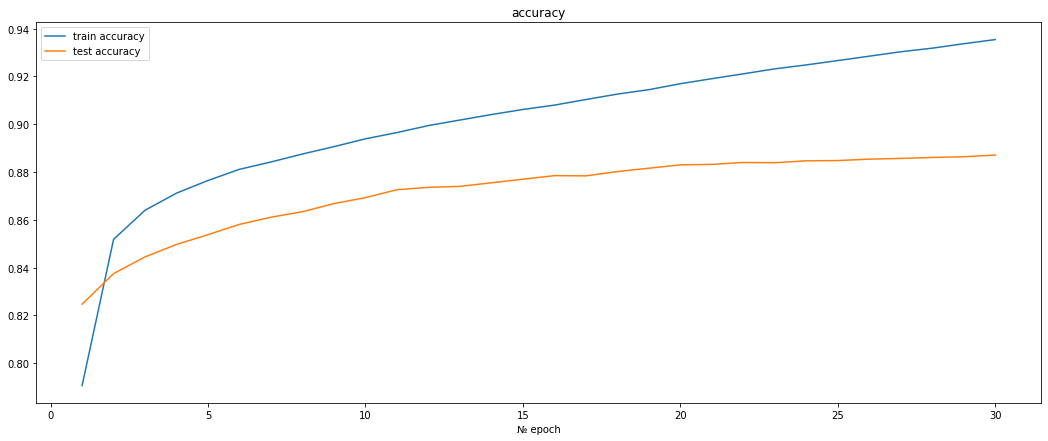

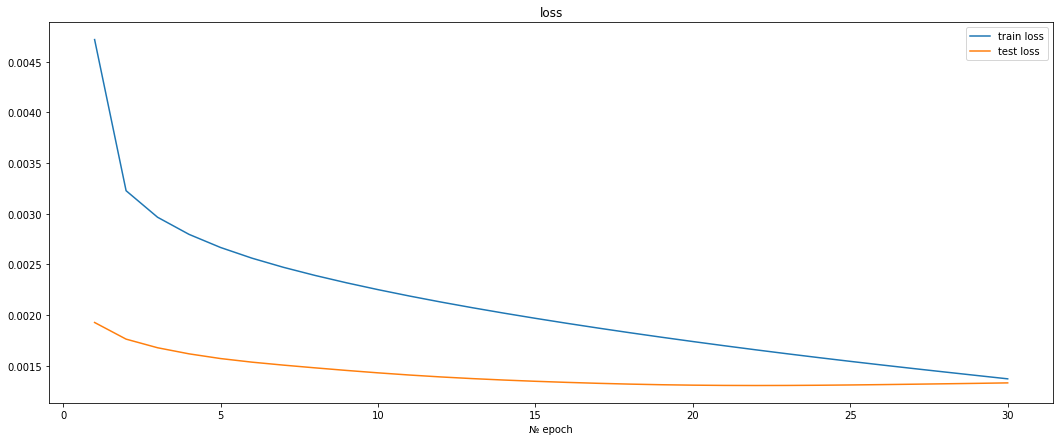

In [ ]:
grid = np.arange(1, epochs + 1)

plt.figure(figsize=(18,7))
plt.plot(grid, train_ac_history, label='train accuracy')
plt.plot(grid, test_ac_history, label='test accuracy')
plt.xlabel("№ epoch")
plt.legend()
plt.title("accuracy")
plt.show()

plt.figure(figsize=(18,7))
plt.plot(grid, train_loss_history, label='train loss')
plt.plot(grid, test_loss_history, label='test loss')
plt.xlabel("№ epoch")
plt.legend()
plt.title("loss")
plt.show()

##### accuracy

In [ ]:
print(f'Test accuracy = {test_ac_history[-1]}')

Test accuracy = 0.8871


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 28*28*2),
            nn.ReLU(),
            nn.Linear(28*28*2, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
              ReLU-3                 [-1, 1568]               0
            Linear-4                  [-1, 512]         803,328
              Tanh-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
              ReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 100]          25,700
              ReLU-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
Total params: 2,192,246
Trainable params: 2,192,246
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 8.36
Estimat

In [ ]:
model_over = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model_over.parameters(), lr=0.0003)
loss_func = nn.CrossEntropyLoss()

epochs = 50

train_loss_history, test_loss_history, train_ac_history, test_ac_history = train_model(epochs, model_over, device, train_loader, test_loader, loss_func, opt)

print(f'final train loss = {train_loss_history[-1]}')
print(f'final train accuracy = {train_ac_history[-1]}')
print(f'final test loss = {test_loss_history[-1]}')
print(f'final test accuracy = {test_ac_history[-1]}')

train loss = 0.004600128472348054
train accuracy = 0.7911
test loss = 0.0017343159437179566
test accuracy = 0.8412
train loss = 0.002941726952791214
train accuracy = 0.8638833333333333
test loss = 0.0015783392906188966
test accuracy = 0.8544
train loss = 0.0026148509686191876
train accuracy = 0.8767333333333334
test loss = 0.001559897594153881
test accuracy = 0.8562
train loss = 0.002388224454969168
train accuracy = 0.8870666666666667
test loss = 0.001524833969771862
test accuracy = 0.8574
train loss = 0.0022174775717159114
train accuracy = 0.89415
test loss = 0.001430111199617386
test accuracy = 0.8669
train loss = 0.002082750142738223
train accuracy = 0.9009333333333334
test loss = 0.0013787547051906585
test accuracy = 0.8727
train loss = 0.0019457893917957942
train accuracy = 0.9075
test loss = 0.0013726041898131371
test accuracy = 0.8753
train loss = 0.0018419339681665103
train accuracy = 0.9120333333333334
test loss = 0.0013456109911203385
test accuracy = 0.8805
train loss = 0.001

##### графики:

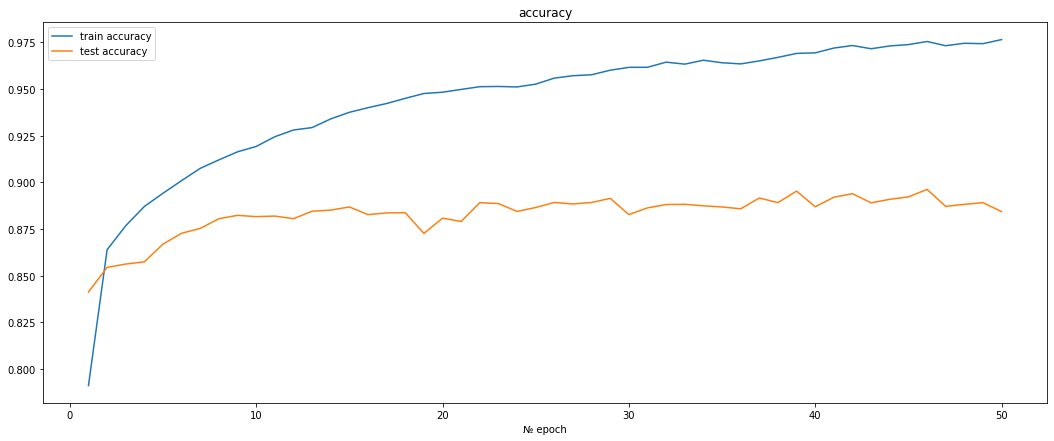

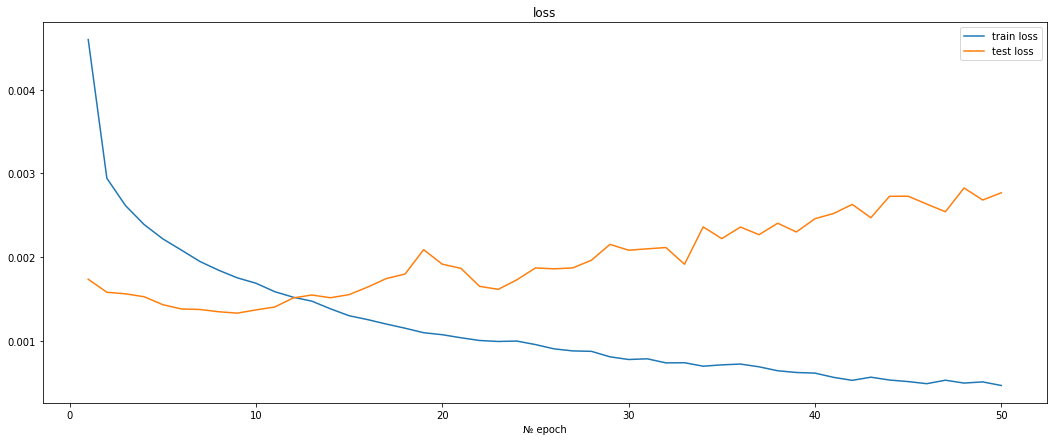

In [ ]:
grid = np.arange(1, epochs + 1)

plt.figure(figsize=(18,7))
plt.plot(grid, train_ac_history, label='train accuracy')
plt.plot(grid, test_ac_history, label='test accuracy')
plt.xlabel("№ epoch")
plt.legend()
plt.title("accuracy")
plt.show()

plt.figure(figsize=(18,7))
plt.plot(grid, train_loss_history, label='train loss')
plt.plot(grid, test_loss_history, label='test loss')
plt.xlabel("№ epoch")
plt.legend()
plt.title("loss")
plt.show()

Обратив внимание на графики, заметно, что модель начинается переобучаться, т.к. test loss быстро растет, a train loss все еще уменьшается

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 28*28*2),
            nn.BatchNorm1d(28*28*2),
            nn.Dropout(0.8),
            nn.ReLU(),
            nn.Linear(28*28*2, 512),
            nn.Dropout(0.8),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(256, 100),
            nn.Dropout(0.8),
            nn.ReLU(),
            nn.Linear(100, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
       BatchNorm1d-3                 [-1, 1568]           3,136
           Dropout-4                 [-1, 1568]               0
              ReLU-5                 [-1, 1568]               0
            Linear-6                  [-1, 512]         803,328
           Dropout-7                  [-1, 512]               0
              Tanh-8                  [-1, 512]               0
            Linear-9                  [-1, 256]         131,328
      BatchNorm1d-10                  [-1, 256]             512
             ReLU-11                  [-1, 256]               0
          Dropout-12                  [-1, 256]               0
           Linear-13                  [-1, 100]          25,700
          Dropout-14                  [

выбрал 20 для лучшей сходимости

In [ ]:
model_fix = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model_fix.parameters(), lr=0.0003, weight_decay=0.008)
loss_func = nn.CrossEntropyLoss()

epochs = 20

train_loss_history, test_loss_history, train_ac_history, test_ac_history = train_model(epochs, model_fix, device, train_loader, test_loader, loss_func, opt)

print(f'final train loss = {train_loss_history[-1]}')
print(f'final train accuracy = {train_ac_history[-1]}')
print(f'final test loss = {test_loss_history[-1]}')
print(f'final test accuracy = {test_ac_history[-1]}')

train loss = 0.016005729005734125
train accuracy = 0.22343333333333334
test loss = 0.004474602794647217
test accuracy = 0.5223
train loss = 0.009619362425804138
train accuracy = 0.4988
test loss = 0.003759285497665405
test accuracy = 0.6585
train loss = 0.0071320000449816385
train accuracy = 0.6261833333333333
test loss = 0.0033419230341911314
test accuracy = 0.7343
train loss = 0.005790106228987376
train accuracy = 0.7102833333333334
test loss = 0.0032244672298431397
test accuracy = 0.752
train loss = 0.004896122578283151
train accuracy = 0.76805
test loss = 0.002944491362571716
test accuracy = 0.7748
train loss = 0.004159890933831533
train accuracy = 0.8157166666666666
test loss = 0.002647546628117561
test accuracy = 0.7835
train loss = 0.003690736283858617
train accuracy = 0.8448166666666667
test loss = 0.0025323122054338454
test accuracy = 0.7888
train loss = 0.0033200312808156014
train accuracy = 0.8682166666666666
test loss = 0.0024809959560632704
test accuracy = 0.7899
train los

##### графики:

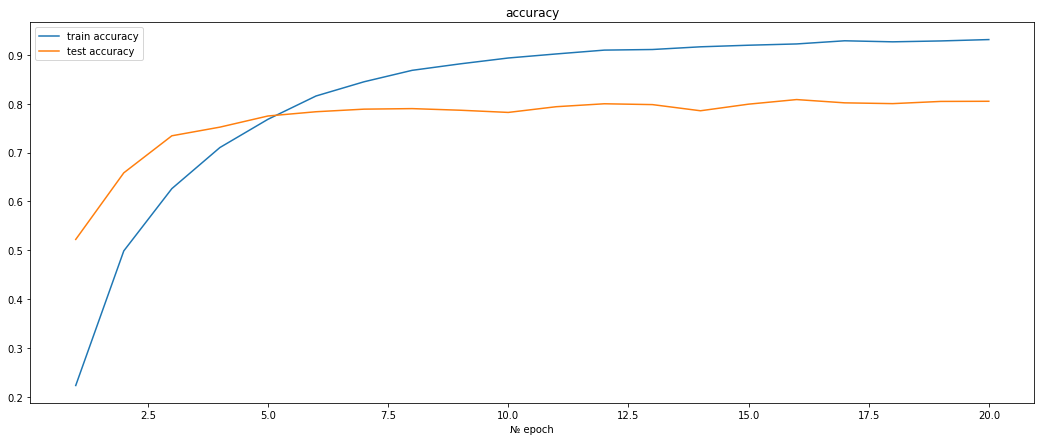

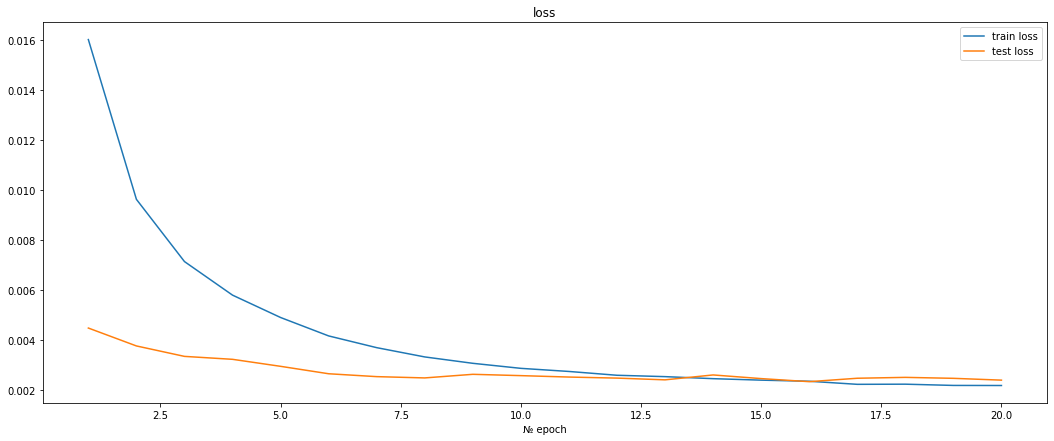

In [ ]:
grid = np.arange(1, epochs + 1)

plt.figure(figsize=(18,7))
plt.plot(grid, train_ac_history, label='train accuracy')
plt.plot(grid, test_ac_history, label='test accuracy')
plt.xlabel("№ epoch")
plt.legend()
plt.title("accuracy")
plt.show()

plt.figure(figsize=(18,7))
plt.plot(grid, train_loss_history, label='train loss')
plt.plot(grid, test_loss_history, label='test loss')
plt.xlabel("№ epoch")
plt.legend()
plt.title("loss")
plt.show()

### Conclusions:

Подводя итоги, можно заметить, что в какой-то момент модель начала переобучаться, для борьбы с переобучением использовались: dropout, batch normalization, l2 regularization.

Из этих трех методов лучшим оказался последний.